In [1]:
import os
import netCDF4
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.image import imread
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation
import datetime
from matplotlib import colors

from scipy import stats

In [2]:
#####################
##  DOWNLOAD DATA  ##
#####################
'''

######################
#REANALYSIS DATA
######################
print('Model Data')
## Download selected month
import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means-preliminary-back-extension',
    {
        'product_type': 'reanalysis-monthly-means-of-daily-means',
        'variable': ['2m_temperature'],
        'year': [
            '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', 
            '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', 
            '1974', '1975', '1976', '1977', '1978'
        ],
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'time': '00:00',
        'area': [-40, -180, -90, 180],
        'format': 'netcdf',
    },
    'ERA5_t2m_1950-1978_prel.nc')

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['2m_temperature'],
        'year': [
            '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', 
            '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
            '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',            
            '2015', '2016', '2017', '2018', '2019', '2020', '2021'
        ],
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'time': '00:00',
        'area': [-40, -180, -90, 180],
        'format': 'netcdf',
    },
    'ERA5_t2m_1979-2020.nc')


#################
# Merge netcdfs
#################
filename_1 = 'ERA5_t2m_1950-1978_prel.nc'
filename_2 = 'ERA5_t2m_1979-2020.nc'

#Load netcdf
ncdf_1 = netCDF4.Dataset(filename_1)
ncdf_2 = netCDF4.Dataset(filename_2)

#Get dimensions
lons = ncdf_2.variables['longitude'][:]
lats = ncdf_2.variables['latitude'][:]
times_1 = ncdf_1.variables['time'][:]
times_2 = ncdf_2.variables['time'][:]
times = np.concatenate([times_1, times_2])

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m_1 = ncdf_1.variables['t2m'][:,:,:]
t2m_2 = ncdf_2.variables['t2m'][:,0,:,:]

t2m = np.concatenate([t2m_1, t2m_2])


#Write numpy array as NetCDF
ncout = netCDF4.Dataset('ERA5_t2m_1950-2020.nc','w','NETCDF4_classic'); # using netCDF3 for output format 
ncout.createDimension('time',np.shape(t2m)[0])
ncout.createDimension('longitude',np.shape(t2m)[2])
ncout.createDimension('latitude',np.shape(t2m)[1])

timevar = ncout.createVariable('time','float64',('time')); timevar.setncattr('units','hours since 1900-01-01 00:00:00.0'); timevar[:]=times;

longitude = ncout.createVariable('longitude','float32',('longitude')); longitude[:] = ncdf_1.variables['longitude'][:];
latitude = ncout.createVariable('latitude','float32',('latitude')); latitude[:] = ncdf_1.variables['latitude'][:];

t2m_join = ncout.createVariable('t2m','float32',('time','latitude','longitude')); t2m_join.setncattr('units','K'); t2m_join[:] = t2m;

ncout.close();
'''

"\n\n######################\n#REANALYSIS DATA\n######################\nprint('Model Data')\n## Download selected month\nimport cdsapi\nc = cdsapi.Client()\n\nc.retrieve(\n    'reanalysis-era5-single-levels-monthly-means-preliminary-back-extension',\n    {\n        'product_type': 'reanalysis-monthly-means-of-daily-means',\n        'variable': ['2m_temperature'],\n        'year': [\n            '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', \n            '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', \n            '1974', '1975', '1976', '1977', '1978'\n        ],\n        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],\n        'time': '00:00',\n        'area': [-40, -180, -90, 180],\n        'format': 'netcdf',\n    },\n    'ERA5_t2m_1950-1978_prel.nc')\n\nc.retrieve(\n    'reanalysis-era5-single-levels-monthly-means',\n    {\n        'product_type': 'mo

In [3]:
#################
# Load data
#################
#Path
#os.chdir('D:\\Bigfiles\\MICROAIRPOLAR\\Climatologia')
filename = 'ERA5_t2m_1950-2020.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename)

#Get dimensions
lons = ncdf.variables['longitude'][:]
lats = ncdf.variables['latitude'][:]
times = ncdf.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf.variables['t2m'][:,:,:]-273.15

In [4]:
#################
# Get latitude of isozero for each longitude
#################

lat0 = np.empty((np.size(dtimes),np.size(lons)))

for j,dtime in enumerate(dtimes[:-1]):
    print(dtime)
    #print(j)
    for i,lon in enumerate(lons):
        ixs = [np.where(t2m[j,:,i] > 0)[0][-1],np.where(t2m[j,:,i] > 0)[0][-1]+1]
        #print(ixs)
        lats_ixs = lats[ixs]
        T_ixs = [t2m[j,ixs[0],i], t2m[j,ixs[1],i]]
        lat0[j,i] = np.interp(0, np.flipud(T_ixs), np.flipud(lats_ixs))

1950-01-01T00
1950-02-01T00
1950-03-01T00
1950-04-01T00
1950-05-01T00
1950-06-01T00
1950-07-01T00
1950-08-01T00
1950-09-01T00
1950-10-01T00
1950-11-01T00
1950-12-01T00
1951-01-01T00
1951-02-01T00
1951-03-01T00
1951-04-01T00
1951-05-01T00
1951-06-01T00
1951-07-01T00
1951-08-01T00
1951-09-01T00
1951-10-01T00
1951-11-01T00
1951-12-01T00
1952-01-01T00
1952-02-01T00
1952-03-01T00
1952-04-01T00
1952-05-01T00
1952-06-01T00
1952-07-01T00
1952-08-01T00
1952-09-01T00
1952-10-01T00
1952-11-01T00
1952-12-01T00
1953-01-01T00
1953-02-01T00
1953-03-01T00
1953-04-01T00
1953-05-01T00
1953-06-01T00
1953-07-01T00
1953-08-01T00
1953-09-01T00
1953-10-01T00
1953-11-01T00
1953-12-01T00
1954-01-01T00
1954-02-01T00
1954-03-01T00
1954-04-01T00
1954-05-01T00
1954-06-01T00
1954-07-01T00
1954-08-01T00
1954-09-01T00
1954-10-01T00
1954-11-01T00
1954-12-01T00
1955-01-01T00
1955-02-01T00
1955-03-01T00
1955-04-01T00
1955-05-01T00
1955-06-01T00
1955-07-01T00
1955-08-01T00
1955-09-01T00
1955-10-01T00
1955-11-01T00
1955-1

1998-12-01T00
1999-01-01T00
1999-02-01T00
1999-03-01T00
1999-04-01T00
1999-05-01T00
1999-06-01T00
1999-07-01T00
1999-08-01T00
1999-09-01T00
1999-10-01T00
1999-11-01T00
1999-12-01T00
2000-01-01T00
2000-02-01T00
2000-03-01T00
2000-04-01T00
2000-05-01T00
2000-06-01T00
2000-07-01T00
2000-08-01T00
2000-09-01T00
2000-10-01T00
2000-11-01T00
2000-12-01T00
2001-01-01T00
2001-02-01T00
2001-03-01T00
2001-04-01T00
2001-05-01T00
2001-06-01T00
2001-07-01T00
2001-08-01T00
2001-09-01T00
2001-10-01T00
2001-11-01T00
2001-12-01T00
2002-01-01T00
2002-02-01T00
2002-03-01T00
2002-04-01T00
2002-05-01T00
2002-06-01T00
2002-07-01T00
2002-08-01T00
2002-09-01T00
2002-10-01T00
2002-11-01T00
2002-12-01T00
2003-01-01T00
2003-02-01T00
2003-03-01T00
2003-04-01T00
2003-05-01T00
2003-06-01T00
2003-07-01T00
2003-08-01T00
2003-09-01T00
2003-10-01T00
2003-11-01T00
2003-12-01T00
2004-01-01T00
2004-02-01T00
2004-03-01T00
2004-04-01T00
2004-05-01T00
2004-06-01T00
2004-07-01T00
2004-08-01T00
2004-09-01T00
2004-10-01T00
2004-1

In [5]:
years = np.arange(1950,2021)
lat0_ANN = np.empty((np.size(years),np.size(lons)))
lat0_MAM = np.empty((np.size(years),np.size(lons)))
lat0_JJA = np.empty((np.size(years),np.size(lons)))
lat0_SON = np.empty((np.size(years),np.size(lons)))
lat0_DJF = np.empty((np.size(years),np.size(lons)))
for i,year in enumerate(np.arange(1950,2021)):
    ix = (year - 1950)*12
    lat0_ANN[i] = np.mean(lat0[ix:ix+12,:], axis=0)
    lat0_MAM[i] = np.mean(lat0[ix+2:ix+2+3,:], axis=0)
    lat0_JJA[i] = np.mean(lat0[ix+5:ix+5+3,:], axis=0)
    lat0_SON[i] = np.mean(lat0[ix+8:ix+8+3,:], axis=0)
    lat0_DJF[i] = np.mean(lat0[ix+11:ix+11+3,:], axis=0)

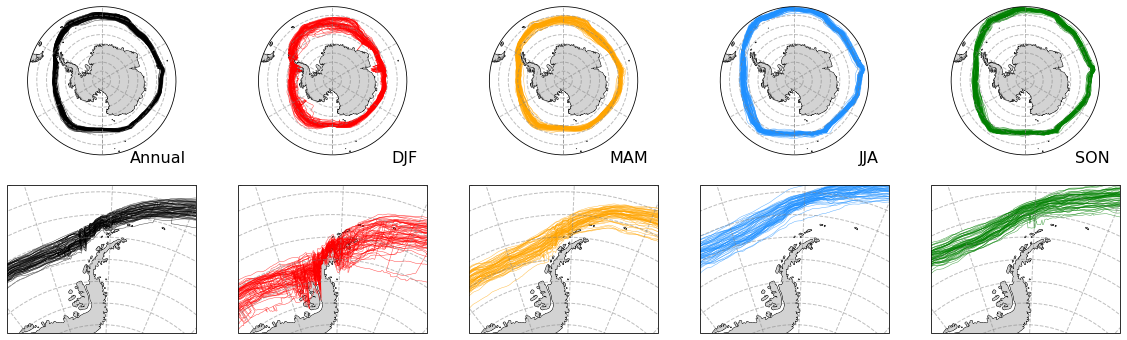

In [6]:
#################
# Plot map lat0
#################
###PLOT MAP###
#Map parameters
fig = plt.figure(figsize=[20,6])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(2,5,1,projection=projection1)
ax2 = plt.subplot(2,5,2,projection=projection1)
ax3 = plt.subplot(2,5,3,projection=projection1)
ax4 = plt.subplot(2,5,4,projection=projection1)
ax5 = plt.subplot(2,5,5,projection=projection1)
ax6 = plt.subplot(2,5,6,projection=projection2)
ax7 = plt.subplot(2,5,7,projection=projection2)
ax8 = plt.subplot(2,5,8,projection=projection2)
ax9 = plt.subplot(2,5,9,projection=projection2)
ax10 = plt.subplot(2,5,10,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)
ax4.set_boundary(circle, transform=ax4.transAxes)
ax5.set_boundary(circle, transform=ax5.transAxes)

#ax.set_extent([AntPen_W, AntPen_E, AntPen_S, AntPen_N], crs=ccrs.PlateCarree(), clip=True)
ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax4.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax5.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax6.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax7.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax8.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax9.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax10.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)
ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax3.coastlines(resolution='50m', facecolor='gray')
ax3.add_feature(land_50m)
ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax4.coastlines(resolution='50m', facecolor='gray')
ax4.add_feature(land_50m)
ax5.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax5.coastlines(resolution='50m', facecolor='gray')
ax5.add_feature(land_50m)
ax6.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax6.coastlines(resolution='50m', facecolor='gray')
ax6.add_feature(land_50m)
ax7.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax7.coastlines(resolution='50m', facecolor='gray')
ax7.add_feature(land_50m)
ax8.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax8.coastlines(resolution='50m', facecolor='gray')
ax8.add_feature(land_50m)
ax9.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax9.coastlines(resolution='50m', facecolor='gray')
ax9.add_feature(land_50m)
ax10.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax10.coastlines(resolution='50m', facecolor='gray')
ax10.add_feature(land_50m)

#Data of lat0
for i,year in enumerate(years[7:]):
    ax1.plot(lons, lat0_ANN[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
    ax2.plot(lons, lat0_DJF[7+i,:], '-', linewidth=0.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7)
    ax3.plot(lons, lat0_MAM[7+i,:], '-', linewidth=0.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
    ax4.plot(lons, lat0_JJA[7+i,:], '-', linewidth=0.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
    ax5.plot(lons, lat0_SON[7+i,:], '-', linewidth=0.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
    ax6.plot(lons, lat0_ANN[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
    ax7.plot(lons, lat0_DJF[7+i,:], '-', linewidth=0.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7)
    ax8.plot(lons, lat0_MAM[7+i,:], '-', linewidth=0.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
    ax9.plot(lons, lat0_JJA[7+i,:], '-', linewidth=0.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
    ax10.plot(lons, lat0_SON[7+i,:], '-', linewidth=0.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
    
#Season
ax1.annotate('Annual', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax2.annotate('DJF', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax3.annotate('MAM', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax4.annotate('JJA', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax5.annotate('SON', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
       
#plt.tight_layout()

#Save files ZIL
np.savetxt('ZIL_1957-2020_lons.csv', lons)
np.savetxt('ZIL_1957-2020_years.csv', years[7:])
np.savetxt('ZIL_1957-2020_ANN.csv',lat0_ANN[7:,:])
np.savetxt('ZIL_1957-2020_DJF.csv',lat0_DJF[7:,:])
np.savetxt('ZIL_1957-2020_MAM.csv',lat0_MAM[7:,:])
np.savetxt('ZIL_1957-2020_JJA.csv',lat0_JJA[7:,:])
np.savetxt('ZIL_1957-2020_SON.csv',lat0_SON[7:,:])

In [7]:
years[7:]

array([1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

C:\Users\gonzalez\AppData\Local\Temp\ipykernel_23532\2000697551.py:137: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


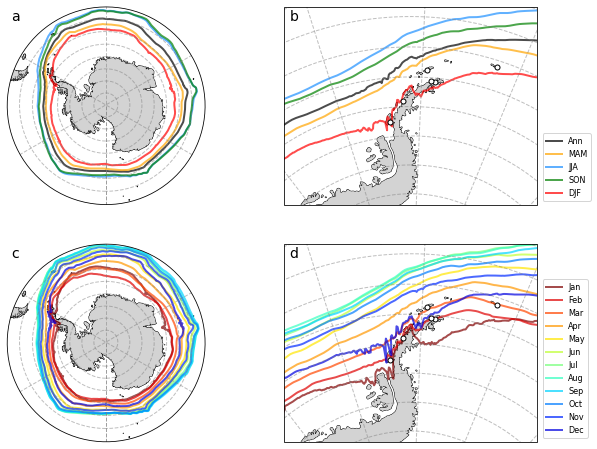

In [8]:
#################
# Plot map seasonal and monthly lat0
#################
### DATA ###
#Get mean seasonal values
lat0_ANN_mean = np.mean(lat0_ANN[7:,:], axis=0)
lat0_MAM_mean = np.mean(lat0_MAM[7:,:], axis=0)
lat0_JJA_mean = np.mean(lat0_JJA[7:,:], axis=0)
lat0_SON_mean = np.mean(lat0_SON[7:,:], axis=0)
lat0_DJF_mean = np.mean(lat0_DJF[7:,:], axis=0)

#Get mean monthly values
lat0_Jan = np.mean(lat0[np.arange(7*12 + 0,854,12),:], axis=0)
lat0_Feb = np.mean(lat0[np.arange(7*12 + 1,854,12),:], axis=0)
lat0_Mar = np.mean(lat0[np.arange(7*12 + 2,854,12),:], axis=0)
lat0_Apr = np.mean(lat0[np.arange(7*12 + 3,854,12),:], axis=0)
lat0_May = np.mean(lat0[np.arange(7*12 + 4,854,12),:], axis=0)
lat0_Jun = np.mean(lat0[np.arange(7*12 + 5,854,12),:], axis=0)
lat0_Jul = np.mean(lat0[np.arange(7*12 + 6,854,12),:], axis=0)
lat0_Aug = np.mean(lat0[np.arange(7*12 + 7,854,12),:], axis=0)
lat0_Sep = np.mean(lat0[np.arange(7*12 + 8,854,12),:], axis=0)
lat0_Oct = np.mean(lat0[np.arange(7*12 + 9,854,12),:], axis=0)
lat0_Nov = np.mean(lat0[np.arange(7*12 + 10,854,12),:], axis=0)
lat0_Dec = np.mean(lat0[np.arange(7*12 + 11,854,12),:], axis=0)


###PLOT MAP###
#Map parameters
fig = plt.figure(figsize=[10,8])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(2,2,1,projection=projection1)
ax2 = plt.subplot(2,2,2,projection=projection2)
ax3 = plt.subplot(2,2,3,projection=projection1)
ax4 = plt.subplot(2,2,4,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax4.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)
ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax3.coastlines(resolution='50m', facecolor='gray')
ax3.add_feature(land_50m)
ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax4.coastlines(resolution='50m', facecolor='gray')
ax4.add_feature(land_50m)


#Data of lat0
ax1.plot(lons, lat0_ANN_mean, '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_MAM_mean, '-', linewidth=2, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_JJA_mean, '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_SON_mean, '-', linewidth=2, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_DJF_mean, '-', linewidth=2, color='r', transform=ccrs.PlateCarree(), alpha=0.7)

ax2.plot(lons, lat0_ANN_mean, '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Ann')
ax2.plot(lons, lat0_MAM_mean, '-', linewidth=2, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7, label='MAM')
ax2.plot(lons, lat0_JJA_mean, '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7, label='JJA')
ax2.plot(lons, lat0_SON_mean, '-', linewidth=2, color='g', transform=ccrs.PlateCarree(), alpha=0.7, label='SON')
ax2.plot(lons, lat0_DJF_mean, '-', linewidth=2, color='r', transform=ccrs.PlateCarree(), alpha=0.7, label='DJF')


colors =  plt.cm.jet_r(np.arange(12)/12)
ax3.plot(lons, lat0_Jan, '-', linewidth=2, color=colors[0], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Feb, '-', linewidth=2, color=colors[1], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Mar, '-', linewidth=2, color=colors[2], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Apr, '-', linewidth=2, color=colors[3], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_May, '-', linewidth=2, color=colors[4], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Jun, '-', linewidth=2, color=colors[5], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Jul, '-', linewidth=2, color=colors[6], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Aug, '-', linewidth=2, color=colors[7], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Sep, '-', linewidth=2, color=colors[8], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Oct, '-', linewidth=2, color=colors[9], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Nov, '-', linewidth=2, color=colors[10], transform=ccrs.PlateCarree(), alpha=0.7)
ax3.plot(lons, lat0_Dec, '-', linewidth=2, color=colors[11], transform=ccrs.PlateCarree(), alpha=0.7)

ax4.plot(lons, lat0_Jan, '-', linewidth=2, color=colors[0], transform=ccrs.PlateCarree(), alpha=0.7, label='Jan')
ax4.plot(lons, lat0_Feb, '-', linewidth=2, color=colors[1], transform=ccrs.PlateCarree(), alpha=0.7, label='Feb')
ax4.plot(lons, lat0_Mar, '-', linewidth=2, color=colors[2], transform=ccrs.PlateCarree(), alpha=0.7, label='Mar')
ax4.plot(lons, lat0_Apr, '-', linewidth=2, color=colors[3], transform=ccrs.PlateCarree(), alpha=0.7, label='Apr')
ax4.plot(lons, lat0_May, '-', linewidth=2, color=colors[4], transform=ccrs.PlateCarree(), alpha=0.7, label='May')
ax4.plot(lons, lat0_Jun, '-', linewidth=2, color=colors[5], transform=ccrs.PlateCarree(), alpha=0.7, label='Jun')
ax4.plot(lons, lat0_Jul, '-', linewidth=2, color=colors[6], transform=ccrs.PlateCarree(), alpha=0.7, label='Jul')
ax4.plot(lons, lat0_Aug, '-', linewidth=2, color=colors[7], transform=ccrs.PlateCarree(), alpha=0.7, label='Aug')
ax4.plot(lons, lat0_Sep, '-', linewidth=2, color=colors[8], transform=ccrs.PlateCarree(), alpha=0.7, label='Sep')
ax4.plot(lons, lat0_Oct, '-', linewidth=2, color=colors[9], transform=ccrs.PlateCarree(), alpha=0.7, label='Oct')
ax4.plot(lons, lat0_Nov, '-', linewidth=2, color=colors[10], transform=ccrs.PlateCarree(), alpha=0.7, label='Nov')
ax4.plot(lons, lat0_Dec, '-', linewidth=2, color=colors[11], transform=ccrs.PlateCarree(), alpha=0.7, label='Dec')

ax2.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.23,0))
ax4.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.22,0))
ax1.annotate('a', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
ax2.annotate('b', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
ax3.annotate('c', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
ax4.annotate('d', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)

#Stations
transform = ccrs.PlateCarree()._as_mpl_transform(ax2)
ax2.plot(-44.7, -60.7,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-58.9, -62.2,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.0, -63.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.9, -63.3,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-64.4, -65.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-68.1, -67.5,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
#Stations
transform = ccrs.PlateCarree()._as_mpl_transform(ax4)
ax4.plot(-44.7, -60.7,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax4.plot(-58.9, -62.2,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax4.plot(-57.0, -63.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax4.plot(-57.9, -63.3,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax4.plot(-64.4, -65.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax4.plot(-68.1, -67.5,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())

plt.tight_layout()

#Save files ZIL
np.savetxt('ZIL_1957-2020_ANN_mean.csv',lat0_ANN_mean)
np.savetxt('ZIL_1957-2020_DJF_mean.csv',lat0_DJF_mean)
np.savetxt('ZIL_1957-2020_MAM_mean.csv',lat0_MAM_mean)
np.savetxt('ZIL_1957-2020_JJA_mean.csv',lat0_JJA_mean)
np.savetxt('ZIL_1957-2020_SON_mean.csv',lat0_SON_mean)

np.savetxt('ZIL_1957-2020_Jan_mean.csv',lat0_Jan)
np.savetxt('ZIL_1957-2020_Feb_mean.csv',lat0_Feb)
np.savetxt('ZIL_1957-2020_Mar_mean.csv',lat0_Mar)
np.savetxt('ZIL_1957-2020_Apr_mean.csv',lat0_Apr)
np.savetxt('ZIL_1957-2020_May_mean.csv',lat0_May)
np.savetxt('ZIL_1957-2020_Jun_mean.csv',lat0_Jun)
np.savetxt('ZIL_1957-2020_Jul_mean.csv',lat0_Jul)
np.savetxt('ZIL_1957-2020_Aug_mean.csv',lat0_Aug)
np.savetxt('ZIL_1957-2020_Sep_mean.csv',lat0_Sep)
np.savetxt('ZIL_1957-2020_Oct_mean.csv',lat0_Oct)
np.savetxt('ZIL_1957-2020_Nov_mean.csv',lat0_Nov) 
np.savetxt('ZIL_1957-2020_Dec_mean.csv',lat0_Dec) 

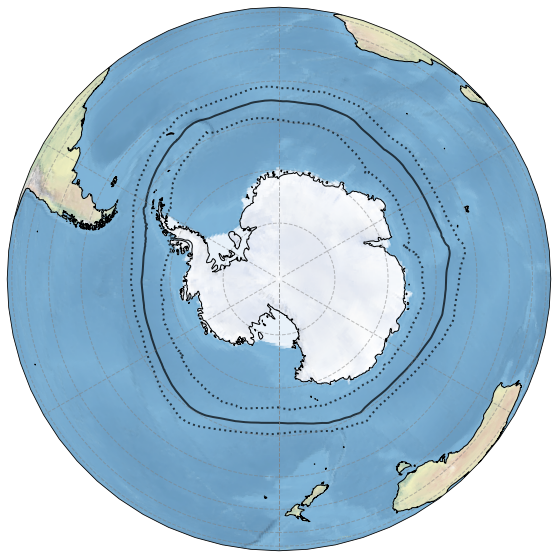

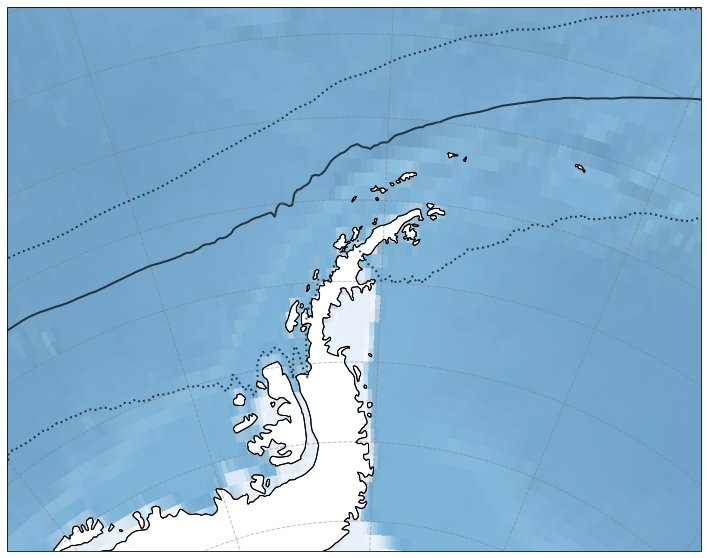

In [9]:
#==============================================================================
# Plot Map
#==============================================================================
##Create figure and projection
fig = plt.figure(figsize=[20,10])
ax1 = plt.subplot(1,1,1, projection=ccrs.NearsidePerspective(central_longitude=0, central_latitude=-90, satellite_height=31000000))

#Add features
ax1.stock_img()
ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='none')
#ax1.add_feature(land_50m, edgecolor='k')
ax1.coastlines(resolution='50m', color='black', linewidth=1, zorder=200)
#ax1.coastlines(zorder=200)

#Plot data
ax1.plot(lons, lat0_Jan, ':', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Jan')
ax1.plot(lons, lat0_Jul, ':', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Jul')
ax1.plot(lons, lat0_ANN_mean, '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7)

#==============================================================================
# Plot Map
#==============================================================================
##Create figure and projection
fig = plt.figure(figsize=[20,10])
ax1 = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None))
ax1.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Add features
ax1.stock_img()
ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='w')
ax1.add_feature(land_50m, edgecolor='k')
ax1.coastlines(resolution='50m', color='black', linewidth=1, zorder=200)
#ax1.coastlines(zorder=200)

#Plot data
ax1.plot(lons, lat0_Jan, ':', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Jan')
ax1.plot(lons, lat0_Jul, ':', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Jul')
ax1.plot(lons, lat0_ANN_mean, '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=0.7)

MovieWriter imagemagick unavailable; using Pillow instead.


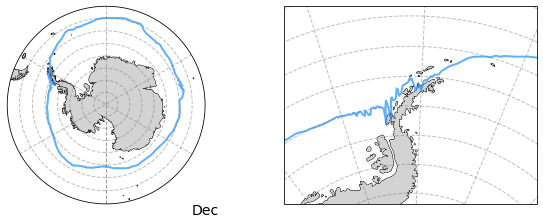

In [10]:
#################
# Animation map monthly Antarctic Peninsula t2m iso0
#################

### DATA OF THE ANIMATION ###
lat0_anim = np.empty((np.size(lons),12))
lat0_anim[:,0] = np.mean(lat0[np.arange(7*12 + 0,854,12),:], axis=0)
lat0_anim[:,1] = np.mean(lat0[np.arange(7*12 + 1,854,12),:], axis=0)
lat0_anim[:,2] = np.mean(lat0[np.arange(7*12 + 2,854,12),:], axis=0)
lat0_anim[:,3] = np.mean(lat0[np.arange(7*12 + 3,854,12),:], axis=0)
lat0_anim[:,4] = np.mean(lat0[np.arange(7*12 + 4,854,12),:], axis=0)
lat0_anim[:,5] = np.mean(lat0[np.arange(7*12 + 5,854,12),:], axis=0)
lat0_anim[:,6] = np.mean(lat0[np.arange(7*12 + 6,854,12),:], axis=0)
lat0_anim[:,7] = np.mean(lat0[np.arange(7*12 + 7,854,12),:], axis=0)
lat0_anim[:,8] = np.mean(lat0[np.arange(7*12 + 8,854,12),:], axis=0)
lat0_anim[:,9] = np.mean(lat0[np.arange(7*12 + 9,854,12),:], axis=0)
lat0_anim[:,10] = np.mean(lat0[np.arange(7*12 + 10,854,12),:], axis=0)
lat0_anim[:,11] = np.mean(lat0[np.arange(7*12 + 11,854,12),:], axis=0)
label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

###PLOT MAP###
fig = plt.figure(figsize=[10,8])
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(2,2,1,projection=projection1)
ax2 = plt.subplot(2,2,2,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)


#Animated data
line1, = ax1.plot([], [], '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
line2, = ax2.plot([], [], '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
label1 = ax1.annotate(label[0], xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=14, zorder=2)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,
def animate(i):
    line1.set_data(lons, lat0_anim[:,i])
    line2.set_data(lons, lat0_anim[:,i])
    label1.set_text(label[i])
    
    return line1, line2,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=12, interval=300, blit=True)


anim.save('Lat0_year_oscillation.gif', writer='imagemagick', dpi=300)

MovieWriter imagemagick unavailable; using Pillow instead.


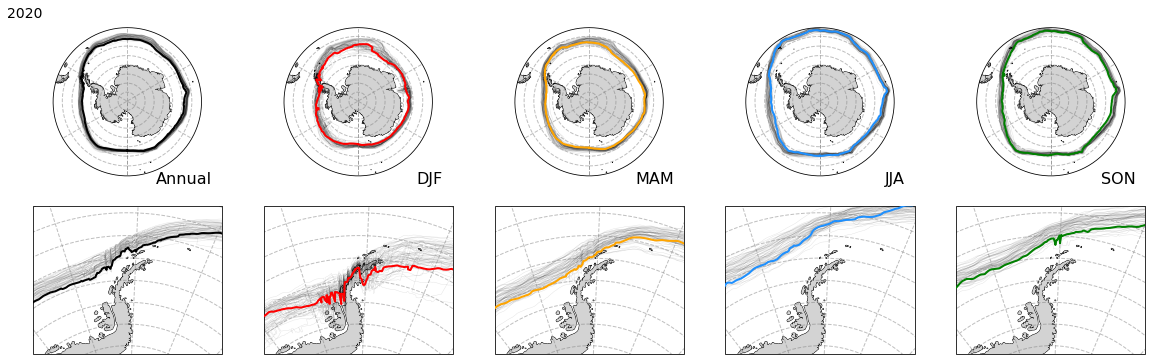

In [11]:
#################
# Plot Animation lat0
#################
###PLOT MAP###
#Map parameters
fig = plt.figure(figsize=[20,6])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(2,5,1,projection=projection1)
ax2 = plt.subplot(2,5,2,projection=projection1)
ax3 = plt.subplot(2,5,3,projection=projection1)
ax4 = plt.subplot(2,5,4,projection=projection1)
ax5 = plt.subplot(2,5,5,projection=projection1)
ax6 = plt.subplot(2,5,6,projection=projection2)
ax7 = plt.subplot(2,5,7,projection=projection2)
ax8 = plt.subplot(2,5,8,projection=projection2)
ax9 = plt.subplot(2,5,9,projection=projection2)
ax10 = plt.subplot(2,5,10,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)
ax4.set_boundary(circle, transform=ax4.transAxes)
ax5.set_boundary(circle, transform=ax5.transAxes)

#ax.set_extent([AntPen_W, AntPen_E, AntPen_S, AntPen_N], crs=ccrs.PlateCarree(), clip=True)
ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax4.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax5.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax6.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax7.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax8.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax9.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
ax10.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)
ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax3.coastlines(resolution='50m', facecolor='gray')
ax3.add_feature(land_50m)
ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax4.coastlines(resolution='50m', facecolor='gray')
ax4.add_feature(land_50m)
ax5.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax5.coastlines(resolution='50m', facecolor='gray')
ax5.add_feature(land_50m)
ax6.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax6.coastlines(resolution='50m', facecolor='gray')
ax6.add_feature(land_50m)
ax7.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax7.coastlines(resolution='50m', facecolor='gray')
ax7.add_feature(land_50m)
ax8.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax8.coastlines(resolution='50m', facecolor='gray')
ax8.add_feature(land_50m)
ax9.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax9.coastlines(resolution='50m', facecolor='gray')
ax9.add_feature(land_50m)
ax10.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax10.coastlines(resolution='50m', facecolor='gray')
ax10.add_feature(land_50m)

#Data of lat0 previous to the year
for i,year in enumerate(years[7:]):
    line_prev_1, = ax1.plot(lons, lat0_ANN[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_2, = ax2.plot(lons, lat0_DJF[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_3, = ax3.plot(lons, lat0_MAM[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_4, = ax4.plot(lons, lat0_JJA[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_5, = ax5.plot(lons, lat0_SON[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_6, = ax6.plot(lons, lat0_ANN[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_7, = ax7.plot(lons, lat0_DJF[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_8, = ax8.plot(lons, lat0_MAM[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_9, = ax9.plot(lons, lat0_JJA[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)
    line_prev_10, = ax10.plot(lons, lat0_SON[7+i,:], '-', linewidth=0.5, color='k', transform=ccrs.PlateCarree(), alpha=0.1)

#Data of lat0 of the year
line_yr_1, = ax1.plot([], [], '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_2, = ax2.plot([], [], '-', linewidth=2, color='r', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_3, = ax3.plot([], [], '-', linewidth=2, color='Orange', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_4, = ax4.plot([], [], '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_5, = ax5.plot([], [], '-', linewidth=2, color='g', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_6, = ax6.plot([], [], '-', linewidth=2, color='k', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_7, = ax7.plot([], [], '-', linewidth=2, color='r', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_8, = ax8.plot([], [], '-', linewidth=2, color='Orange', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_9, = ax9.plot([], [], '-', linewidth=2, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=1, zorder=50)
line_yr_10, = ax10.plot([], [], '-', linewidth=2, color='g', transform=ccrs.PlateCarree(), alpha=1, zorder=50)

#Season
ax1.annotate('Annual', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax2.annotate('DJF', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax3.annotate('MAM', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax4.annotate('JJA', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)
ax5.annotate('SON', xy=(1.07, -.05), xycoords='axes fraction', ha='right', fontsize=16, zorder=2)

label1 = ax1.annotate(years[0], xy=(-0.07, 1.07), xycoords='axes fraction', ha='right', fontsize=14, zorder=2)
        
#plt.tight_layout()

def init():
    label1.set_text([])
    #line_prev_1.set_data([], [])
    #line_prev_2.set_data([], [])
    #line_prev_3.set_data([], [])
    #line_prev_4.set_data([], [])
    #line_prev_5.set_data([], [])
    #line_prev_6.set_data([], [])
    #line_prev_7.set_data([], [])
    #line_prev_8.set_data([], [])
    #line_prev_9.set_data([], [])
    #line_prev_10.set_data([], [])
    line_yr_1.set_data([], [])
    line_yr_2.set_data([], [])
    line_yr_3.set_data([], [])
    line_yr_4.set_data([], [])
    line_yr_5.set_data([], [])
    line_yr_6.set_data([], [])
    line_yr_7.set_data([], [])
    line_yr_8.set_data([], [])
    line_yr_9.set_data([], [])
    line_yr_10.set_data([], [])
    #return line_prev_1, line_prev_2, line_prev_3, line_prev_4, line_prev_5, line_prev_6, line_prev_7, line_prev_8, line_prev_9, line_prev_10, line_yr_1, line_yr_2, line_yr_3, line_yr_4, line_yr_5, line_yr_6, line_yr_7, line_yr_8, line_yr_9, line_yr_10
    return line_yr_1, line_yr_2, line_yr_3, line_yr_4, line_yr_5, line_yr_6, line_yr_7, line_yr_8, line_yr_9, line_yr_10

def animate(i):
    label1.set_text(years[7+i])
    #line_prev_1.set_data(lons, lat0_ANN[:i,:])
    #line_prev_2.set_data(lons, lat0_MAM[:i,:])
    #line_prev_3.set_data(lons, lat0_JJA[:i,:])
    #line_prev_4.set_data(lons, lat0_SON[:i,:])
    #line_prev_5.set_data(lons, lat0_DJF[:i,:])
    #line_prev_6.set_data(lons, lat0_ANN[:i,:])
    #line_prev_7.set_data(lons, lat0_MAM[:i,:])
    #line_prev_8.set_data(lons, lat0_JJA[:i,:])
    #line_prev_9.set_data(lons, lat0_SON[:i,:])
    #line_prev_10.set_data(lons, lat0_DJF[:i,:])
    line_yr_1.set_data(lons, lat0_ANN[7+i,:])
    line_yr_2.set_data(lons, lat0_DJF[7+i,:])
    line_yr_3.set_data(lons, lat0_MAM[7+i,:])
    line_yr_4.set_data(lons, lat0_JJA[7+i,:])
    line_yr_5.set_data(lons, lat0_SON[7+i,:])
    line_yr_6.set_data(lons, lat0_ANN[7+i,:])
    line_yr_7.set_data(lons, lat0_DJF[7+i,:])
    line_yr_8.set_data(lons, lat0_MAM[7+i,:])
    line_yr_9.set_data(lons, lat0_JJA[7+i,:])
    line_yr_10.set_data(lons, lat0_SON[7+i,:])
    #return label1, line_prev_1, line_prev_2, line_prev_3, line_prev_4, line_prev_5, line_prev_6, line_prev_7, line_prev_8, line_prev_9, line_prev_10, line_yr_1, line_yr_2, line_yr_3, line_yr_4, line_yr_5, line_yr_6, line_yr_7, line_yr_8, line_yr_9, line_yr_10
    return label1, line_yr_1, line_yr_2, line_yr_3, line_yr_4, line_yr_5, line_yr_6, line_yr_7, line_yr_8, line_yr_9, line_yr_10
    
anim = FuncAnimation(fig, animate, init_func=init, frames=np.size(years)-7, interval=300, repeat_delay=1000, blit=True)

anim.save('Lat0_evolution.gif', writer='imagemagick', dpi=300)

In [12]:
years[-1]

2020

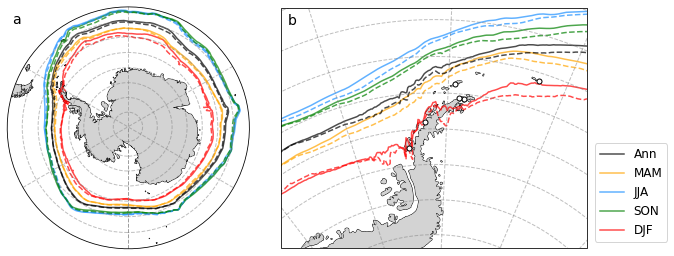

In [13]:
#################
# Plot map climatic and decadal evolution Antarctic Peninsula t2m iso0
#################
### DATA ###
#Get 30 yr averages seasonal values
lat0_ANN_mean_1961_1990 = np.mean(lat0_ANN[11:41,:], axis=0)
lat0_MAM_mean_1961_1990 = np.mean(lat0_MAM[11:41,:], axis=0)
lat0_JJA_mean_1961_1990 = np.mean(lat0_JJA[11:41,:], axis=0)
lat0_SON_mean_1961_1990 = np.mean(lat0_SON[11:41,:], axis=0)
lat0_DJF_mean_1961_1990 = np.mean(lat0_DJF[11:41,:], axis=0)

lat0_ANN_mean_1991_2020 = np.mean(lat0_ANN[41:,:], axis=0)
lat0_MAM_mean_1991_2020 = np.mean(lat0_MAM[41:,:], axis=0)
lat0_JJA_mean_1991_2020 = np.mean(lat0_JJA[41:,:], axis=0)
lat0_SON_mean_1991_2020 = np.mean(lat0_SON[41:,:], axis=0)
lat0_DJF_mean_1991_2020 = np.mean(lat0_DJF[41:,:], axis=0)


###PLOT MAP###
#Map parameters
fig = plt.figure(figsize=[10,4])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(1,2,1,projection=projection1)
ax2 = plt.subplot(1,2,2,projection=projection2)
#ax3 = plt.subplot(2,2,3,projection=projection1)
#ax4 = plt.subplot(2,2,4,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#ax3.set_boundary(circle, transform=ax3.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
#ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
#ax4.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)
#ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax3.coastlines(resolution='50m', facecolor='gray')
#ax3.add_feature(land_50m)
#ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax4.coastlines(resolution='50m', facecolor='gray')
#ax4.add_feature(land_50m)


#Data of lat0
ax1.plot(lons, lat0_ANN_mean_1961_1990, '-', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_MAM_mean_1961_1990, '-', linewidth=1.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_JJA_mean_1961_1990, '-', linewidth=1.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_SON_mean_1961_1990, '-', linewidth=1.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_DJF_mean_1961_1990, '-', linewidth=1.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_ANN_mean_1991_2020, '--', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_MAM_mean_1991_2020, '--', linewidth=1.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_JJA_mean_1991_2020, '--', linewidth=1.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_SON_mean_1991_2020, '--', linewidth=1.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_DJF_mean_1991_2020, '--', linewidth=1.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7)

ax2.plot(lons, lat0_ANN_mean_1961_1990, '-', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Ann')
ax2.plot(lons, lat0_MAM_mean_1961_1990, '-', linewidth=1.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7, label='MAM')
ax2.plot(lons, lat0_JJA_mean_1961_1990, '-', linewidth=1.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7, label='JJA')
ax2.plot(lons, lat0_SON_mean_1961_1990, '-', linewidth=1.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7, label='SON')
ax2.plot(lons, lat0_DJF_mean_1961_1990, '-', linewidth=1.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7, label='DJF')
ax2.plot(lons, lat0_ANN_mean_1991_2020, '--', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
ax2.plot(lons, lat0_MAM_mean_1991_2020, '--', linewidth=1.5, color='Orange', transform=ccrs.PlateCarree(), alpha=0.7)
ax2.plot(lons, lat0_JJA_mean_1991_2020, '--', linewidth=1.5, color='DodgerBlue', transform=ccrs.PlateCarree(), alpha=0.7)
ax2.plot(lons, lat0_SON_mean_1991_2020, '--', linewidth=1.5, color='g', transform=ccrs.PlateCarree(), alpha=0.7)
ax2.plot(lons, lat0_DJF_mean_1991_2020, '--', linewidth=1.5, color='r', transform=ccrs.PlateCarree(), alpha=0.7)

ax2.legend(loc='lower right', fontsize=12, bbox_to_anchor=(1.28,0))
#ax4.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.22,0))
ax1.annotate('a', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
ax2.annotate('b', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
#ax3.annotate('c', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
#ax4.annotate('d', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace=0.00)

#Stations
transform = ccrs.PlateCarree()._as_mpl_transform(ax2)
ax2.plot(-44.7, -60.7,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
#ax2.annotate('Orcadas', color='r', xy=(-44.7, -60.7), xycoords=transform, fontsize=12, transform=ccrs.PlateCarree())
ax2.plot(-58.9, -62.2,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.0, -63.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.9, -63.3,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-64.4, -65.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-68.1, -67.5,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())

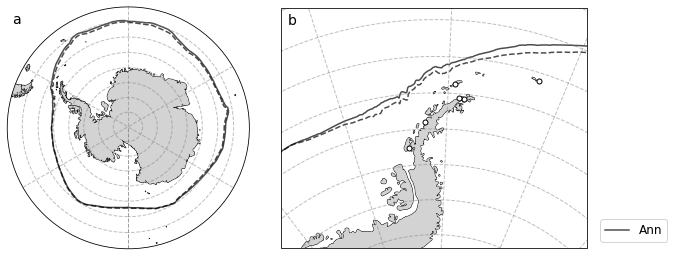

In [14]:
#################
# Plot map climatic and decadal evolution Antarctic Peninsula t2m iso0
#################
### DATA ###
#Get 30 yr averages seasonal values
lat0_ANN_mean_1961_1990 = np.mean(lat0_ANN[11:41,:], axis=0)
lat0_ANN_mean_1991_2020 = np.mean(lat0_ANN[41:,:], axis=0)


###PLOT MAP###
#Map parameters
fig = plt.figure(figsize=[10,4])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(1,2,1,projection=projection1)
ax2 = plt.subplot(1,2,2,projection=projection2)
#ax3 = plt.subplot(2,2,3,projection=projection1)
#ax4 = plt.subplot(2,2,4,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#ax3.set_boundary(circle, transform=ax3.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
#ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())
#ax4.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
ax2.add_feature(land_50m)
#ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax3.coastlines(resolution='50m', facecolor='gray')
#ax3.add_feature(land_50m)
#ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax4.coastlines(resolution='50m', facecolor='gray')
#ax4.add_feature(land_50m)


#Data of lat0
ax1.plot(lons, lat0_ANN_mean_1961_1990, '-', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)
ax1.plot(lons, lat0_ANN_mean_1991_2020, '--', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)

ax2.plot(lons, lat0_ANN_mean_1961_1990, '-', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7, label='Ann')
ax2.plot(lons, lat0_ANN_mean_1991_2020, '--', linewidth=1.5, color='k', transform=ccrs.PlateCarree(), alpha=0.7)

ax2.legend(loc='lower right', fontsize=12, bbox_to_anchor=(1.28,0))
#ax4.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.22,0))
ax1.annotate('a', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
ax2.annotate('b', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
#ax3.annotate('c', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)
#ax4.annotate('d', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=14)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace=0.00)

#Stations
transform = ccrs.PlateCarree()._as_mpl_transform(ax2)
ax2.plot(-44.7, -60.7,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
#ax2.annotate('Orcadas', color='r', xy=(-44.7, -60.7), xycoords=transform, fontsize=12, transform=ccrs.PlateCarree())
ax2.plot(-58.9, -62.2,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.0, -63.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.9, -63.3,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-64.4, -65.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-68.1, -67.5,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())

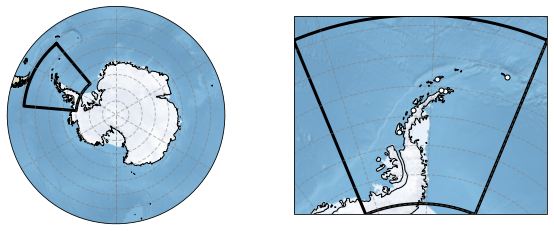

In [15]:
#################
# Plot map Antarctic Peninsula t20 iso0
#################
#Map parameters
fig = plt.figure(figsize=[10,4])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=-62.5, true_scale_latitude=None)

ax1 = plt.subplot(1,2,1,projection=projection1)
ax2 = plt.subplot(1,2,2,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#ax1.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=False, linewidth=.5, color='k', alpha=1, linestyle='-')
#ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=.5, color='k', alpha=1, linestyle='-')
ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

ax1.coastlines(resolution='50m')
ax2.coastlines(resolution='50m')

#Background
ax1.imshow(imread('D:\\Mega\\UBUNTU\\Jupyter\\Cartopy_Background_image\\natural-earth-1_large2048px.png'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180,180,-90,90])
ax2.imshow(imread('D:\\Mega\\UBUNTU\\Jupyter\\Cartopy_Background_image\\natural-earth-1_large2048px.png'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180,180,-90,90])

#Area selected
rec_lons = [-40, -85]
rec_lats = [-56, -75]
rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
ax1.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=3, transform=ccrs.PlateCarree())
ax2.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=3, transform=ccrs.PlateCarree())

#rec_lons = [-55, -70]
#rec_lats = [-56, -75]
#rec_lons_array = np.concatenate([np.linspace(rec_lons[0], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[1], 50), np.linspace(rec_lons[1], rec_lons[0], 50), np.linspace(rec_lons[0], rec_lons[0], 50)])
#rec_lats_array = np.concatenate([np.linspace(rec_lats[0], rec_lats[0], 50), np.linspace(rec_lats[0], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[1], 50), np.linspace(rec_lats[1], rec_lats[0], 50)])
#ax2.plot(rec_lons_array, rec_lats_array, '-', color='k', linewidth=1.5, transform=ccrs.PlateCarree())

#Stations
transform = ccrs.PlateCarree()._as_mpl_transform(ax2)
ax2.plot(-44.7, -60.7,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
#ax2.annotate('Orcadas', color='r', xy=(-44.7, -60.7), xycoords=transform, fontsize=12, transform=ccrs.PlateCarree())
ax2.plot(-58.9, -62.2,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.0, -63.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-57.9, -63.3,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-64.4, -65.4,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())
ax2.plot(-68.1, -67.5,'o', color='white', markersize=5, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())

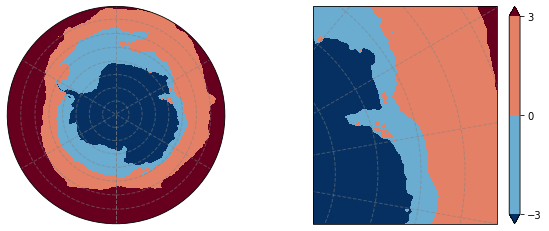

In [16]:
#################
# Plot interesting details: Amery 2004
#################
###PLOT MAP###
#Find index date to plot
index_date_ini = np.where(dtimes == np.datetime64('2004-01-01T00'))[0][0]
index_date_end = np.where(dtimes == np.datetime64('2004-02-01T00'))[0][0]

#Map parameters
fig = plt.figure(figsize=[10,4])

#Map
projection1 = ccrs.SouthPolarStereo(central_longitude=0)
projection2 = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude=None)

ax1 = plt.subplot(1,2,1,projection=projection1)
ax2 = plt.subplot(1,2,2,projection=projection2)
#ax3 = plt.subplot(2,2,3,projection=projection1)
#ax4 = plt.subplot(2,2,4,projection=projection2)

#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#ax3.set_boundary(circle, transform=ax3.transAxes)

ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
#ax3.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax2.set_extent([55, 100, -75, -56], crs=ccrs.PlateCarree())
#ax4.set_extent([-85, -40, -75, -56], crs=ccrs.PlateCarree())

#Background
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='LightGray')

ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines(resolution='50m', facecolor='gray')
#ax1.add_feature(land_50m)
ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines(resolution='50m', facecolor='gray')
#ax2.add_feature(land_50m)
#ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax3.coastlines(resolution='50m', facecolor='gray')
#ax3.add_feature(land_50m)
#ax4.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax4.coastlines(resolution='50m', facecolor='gray')
#ax4.add_feature(land_50m)

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

orig_cmap = mpl.cm.RdBu_r
shifted_cmap = shiftedColorMap(orig_cmap, start=-20., midpoint=0, stop=5., name='shifted')

#Data of lat0
CS1 = ax1.contourf(lons, lats, np.mean(t2m[index_date_ini:index_date_end,:,:],axis=0), levels=np.arange(-3,3.5,3), cmap=orig_cmap, extend='both', transform=ccrs.PlateCarree())
CS2 = ax2.contourf(lons, lats, np.mean(t2m[index_date_ini:index_date_end,:,:],axis=0), levels=np.arange(-3,3.5,3), cmap=orig_cmap, extend='both', transform=ccrs.PlateCarree())
plt.colorbar(CS2)